In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.signal import convolve2d
from scipy.io import loadmat
from sklearn.utils import shuffle

from benchmark import get_data, y2indicator, error_rate

C:\Users\Denis\AppData\Local\conda\conda\envs\tensorflow_env_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def convpool(X, W, b):
    # just assume pool size is (2,2) because we need to augment it with 1s
    conv_out = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    pool_out = tf.nn.max_pool(conv_out, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return tf.nn.relu(pool_out)

def init_filter(shape, poolsz):
    # w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2]) / np.prod(poolsz))
    w = np.random.randn(*shape) * np.sqrt(2.0 / np.prod(shape[:-1]))
    return w.astype(np.float32)

def rearrange(X):
    # input is (32, 32, 3, N)
    # output is (N, 32, 32, 3)
    # N = X.shape[-1]
    # out = np.zeros((N, 32, 32, 3), dtype=np.float32)
    # for i in xrange(N):
    #     for j in xrange(3):
    #         out[i, :, :, j] = X[:, :, j, i]
    # return out / 255
    return (X.transpose(3, 0, 1, 2) / 255).astype(np.float32)

In [3]:
train, test = get_data()

# Need to scale! don't leave as 0..255
# Y is a N x 1 matrix with values 1..10 (MATLAB indexes by 1)
# So flatten it and make it 0..9
# Also need indicator matrix for cost calculation
Xtrain = rearrange(train['X'])
Ytrain = train['y'].flatten() - 1
# print len(Ytrain)
del train
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
Ytrain_ind = y2indicator(Ytrain)

Xtest  = rearrange(test['X'])
Ytest  = test['y'].flatten() - 1
del test
Ytest_ind  = y2indicator(Ytest)

# gradient descent params
max_iter = 6
print_period = 10
N = Xtrain.shape[0]
batch_sz = 500
n_batches = N // batch_sz

# limit samples since input will always have to be same size
# you could also just do N = N / batch_sz * batch_sz
Xtrain = Xtrain[:73000,]
Ytrain = Ytrain[:73000]
Xtest = Xtest[:26000,]
Ytest = Ytest[:26000]
Ytest_ind = Ytest_ind[:26000,]
print("Xtest.shape:", Xtest.shape)
print("Ytest.shape:", Ytest.shape)

Xtest.shape: (26000, 32, 32, 3)
Ytest.shape: (26000,)


In [4]:
# initial weights
M = 500
K = 10
poolsz = (2, 2)

W1_shape = (5, 5, 3, 20) # (filter_width, filter_height, num_color_channels, num_feature_maps)
W1_init = init_filter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[-1], dtype=np.float32) # one bias per output feature map

W2_shape = (5, 5, 20, 50) # (filter_width, filter_height, old_num_feature_maps, num_feature_maps)
W2_init = init_filter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[-1], dtype=np.float32)

In [5]:
# vanilla ANN weights
W3_init = np.random.randn(W2_shape[-1]*8*8, M) / np.sqrt(W2_shape[-1]*8*8 + M)
b3_init = np.zeros(M, dtype=np.float32)
W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_init = np.zeros(K, dtype=np.float32)

In [6]:
# define variables and expressions
# using None as the first shape element takes up too much RAM unfortunately
X = tf.placeholder(tf.float32, shape=(batch_sz, 32, 32, 3), name='X')
T = tf.placeholder(tf.float32, shape=(batch_sz, K), name='T')
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))
W4 = tf.Variable(W4_init.astype(np.float32))
b4 = tf.Variable(b4_init.astype(np.float32))

In [7]:
Z1 = convpool(X, W1, b1)
Z2 = convpool(Z1, W2, b2)
Z2_shape = Z2.get_shape().as_list()
Z2r = tf.reshape(Z2, [Z2_shape[0], np.prod(Z2_shape[1:])])
Z3 = tf.nn.relu( tf.matmul(Z2r, W3) + b3 )
Yish = tf.matmul(Z3, W4) + b4

cost = tf.reduce_sum(
    tf.nn.softmax_cross_entropy_with_logits(
        logits=Yish,
        labels=T
    )
)

train_op = tf.train.RMSPropOptimizer(0.0001, decay=0.99, momentum=0.9).minimize(cost)

# we'll use this to calculate the error rate
predict_op = tf.argmax(Yish, 1)

Cost / err at iteration i=0, j=0: 65693.224 / 0.818
Cost / err at iteration i=0, j=10: 58091.844 / 0.804
Cost / err at iteration i=0, j=20: 57892.557 / 0.804
Cost / err at iteration i=0, j=30: 57405.893 / 0.771
Cost / err at iteration i=0, j=40: 56270.324 / 0.745
Cost / err at iteration i=0, j=50: 53439.042 / 0.712
Cost / err at iteration i=0, j=60: 48560.681 / 0.545
Cost / err at iteration i=0, j=70: 41020.521 / 0.490
Cost / err at iteration i=0, j=80: 35212.803 / 0.463
Cost / err at iteration i=0, j=90: 29330.328 / 0.345
Cost / err at iteration i=0, j=100: 25635.542 / 0.298
Cost / err at iteration i=0, j=110: 22289.200 / 0.241
Cost / err at iteration i=0, j=120: 21013.929 / 0.232
Cost / err at iteration i=0, j=130: 19612.841 / 0.210
Cost / err at iteration i=0, j=140: 18588.811 / 0.202
Cost / err at iteration i=1, j=0: 19207.653 / 0.209
Cost / err at iteration i=1, j=10: 17760.973 / 0.187
Cost / err at iteration i=1, j=20: 17664.988 / 0.191
Cost / err at iteration i=1, j=30: 17349.37

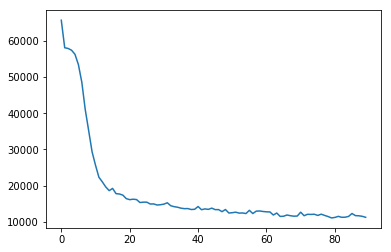

In [8]:
t0 = datetime.now()
LL = []
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)

    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

            if len(Xbatch) == batch_sz:
                session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
                if j % print_period == 0:
                    # due to RAM limitations we need to have a fixed size input
                    # so as a result, we have this ugly total cost and prediction computation
                    test_cost = 0
                    prediction = np.zeros(len(Xtest))
                    for k in range(len(Xtest) // batch_sz):
                        Xtestbatch = Xtest[k*batch_sz:(k*batch_sz + batch_sz),]
                        Ytestbatch = Ytest_ind[k*batch_sz:(k*batch_sz + batch_sz),]
                        test_cost += session.run(cost, feed_dict={X: Xtestbatch, T: Ytestbatch})
                        prediction[k*batch_sz:(k*batch_sz + batch_sz)] = session.run(
                            predict_op, feed_dict={X: Xtestbatch})
                    err = error_rate(prediction, Ytest)
                    print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                    LL.append(test_cost)
print("Elapsed time:", (datetime.now() - t0))
plt.plot(LL)
plt.show()